## **Data Prep**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [4]:
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_te, y_train, y_te = train_test_split(X_vec, y_vec, test_size=0.2, random_state=1)
x_train, x_va, y_train, y_va = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [6]:
print("x_train, nr sample {}, nr feature {}".format(x_train.shape[0],x_train.shape[1]))
print("x_va,    nr sample {}, nr feature {}".format(x_va.shape[0],x_va.shape[1]))
print("x_te,    nr sample {}, nr feature {}".format(x_te.shape[0],x_te.shape[1]))
print("Tr: Pos {} Neg {}".format(y_train[y_train==1].shape[0],y_train[y_train==0].shape[0]))
print("Va: Pos {} Neg {}".format(y_va[y_va==1].shape[0],y_va[y_va==0].shape[0]))
print("Te: Pos {} Neg {}".format(y_te[y_te==1].shape[0],y_te[y_te==0].shape[0]))

x_train, nr sample 42000, nr feature 28
x_va,    nr sample 14000, nr feature 28
x_te,    nr sample 14000, nr feature 28
Tr: Pos 4701 Neg 4133
Va: Pos 1544 Neg 1390
Te: Pos 1632 Neg 1380


In [7]:
x_train[0].shape

(28, 28, 3)

Text(0.5, 1.0, 'Digit: 5')

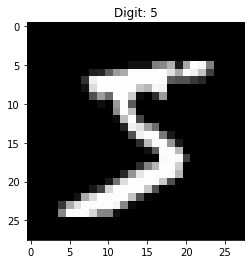

In [8]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

## **Pipeline**

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [10]:
simple_rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7f06dc10f6d0>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f06dc10f670>),
                ('RF', RandomForestClassifier())])

# **Training model on the full data set**

In [17]:
import numpy as np
from scipy import sparse
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

y_va_pred = simple_rf_pipeline.predict_proba(x_va)# [:,1] #WHY DID THAT WORK?
#predict_proba : Probability estimates. The returned estimates for all classes are ordered by the label of classes.
print(y_va_pred.shape)
full_logloss = log_loss(y_va,y_va_pred) 

#Log loss, aka logistic loss or cross-entropy loss. This is the loss function defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true. 
#For a single sample with true label yt in {0,1} and estimated probability yp that yt = 1, the log loss is
#-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

#weight_ar = simple_rf_pipeline.coef_.flatten() BE CAREFUL IF THIS IS BEING USED SOMEWHERE

#Coefficient of the features in the decision function. coef_ is of shape (1, n_features) when the given problem is binary.

# on Te

y_te_pred = simple_rf_pipeline.predict_proba(x_te) #[:,1]
full_te_logloss = log_loss(y_te,y_te_pred)
full_te_auc = roc_auc_score(y_te, y_te_pred, multi_class='ovo')
#The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
# The true-positive rate is also known as sensitivity, recall or probability of detection
# The false-positive rate is also known as probability of false alarm 
# AUC measures how true positive rate (recall) and false positive rate trade off

y_te_pred = simple_rf_pipeline.predict(x_te)
full_te_acc = (y_te == y_te_pred).sum() / y_te.shape[0]


# print full-set-model results
print("[FullSet] Va logloss {:.6f}".format(full_logloss))
print("[FullSet] Te logloss {:.6f}".format(full_te_logloss))

(14000, 10)
[FullSet] Va logloss 0.277149
[FullSet] Te logloss 0.280804


In [48]:
y_va_pred_val = y_va_pred
y_va_new = []

for row in range(y_va_pred.shape[0]):
    max_val = max(y_va_pred[row])

    for i in range(len(y_va_pred[row])):

        if y_va_pred[row][i] == max_val:
            y_va_new.append(int(i))
            break

In [49]:
import pandas as pd
y_va_new = pd.Series(y_va_new)

## **Influence Value for each training sample**

In [123]:
def grad_logloss_theta_lr(label,ypred,x,C=0.03,has_l2=True,scale_factor=1.0):
    """Return d l_i / d_theta = d l_i / d_ypred * d y_pred / d theta
        grad_logloss_theta: gradient on the theta, shape: [n,]
    """
    # The isinstance() function returns True if the specified object is of the specified type, otherwise False.
    if not isinstance(label,np.ndarray) or not isinstance(ypred,np.ndarray):
        label = np.array(label).flatten()
        ypred = np.array(ypred).flatten()


    grad_logloss_theta = C * x.T.dot(ypred-label)

    return scale_factor * grad_logloss_theta

def batch_grad_logloss_lr(label,ypred,x,C=0.03,scale_factor=1.0):
    """Return gradient on a batch.
        batch_grad: gradient of each sample on parameters,
            has shape [None,n]
    """
    
    # diffs = ypred - label
    # for i in range(len(ypred)):
    #     print(ypred[i] - label[i])
    #     break

    ypred = ypred.tolist()
    label = label.tolist()
    diffs = [x1 - x2 for (x1, x2) in zip(ypred, label)]

    #diffs = ypred-label

    diffs = pd.Series(diffs)
    ypred = pd.Series(ypred)
    label = pd.Series(label)
    
    # diffs = pd.Series(diffs)
    # print(ypred.shape)
    # print(label.shape)
    # print(diffs.shape)
    #print(diffs.isna().sum())
    
    
    if isinstance(x,np.ndarray):
        x = x.astype(np.float32) / 255
        x = np.reshape(x, [x.shape[0], -1])

        #print(x.shape, diffs.shape)
        diffs = diffs.values.reshape(-1,1)
        batch_grad = x * diffs
    else:
        diffs = sparse.diags(diffs)
        batch_grad = x.T.dot(diffs).T
    batch_grad = sparse.csr_matrix(C * batch_grad)      
    return scale_factor * batch_grad

In [143]:
# building precoditioner
from turtle import goto

C = 0.1
num_tr_sample = x_train.shape[0]


test_grad_loss_val = grad_logloss_theta_lr(y_va,y_va_new,x_va,C ,0.1/(num_tr_sample*C))  #Return d l_i / d_theta

tr_pred = simple_rf_pipeline.predict_proba(x_train) #[:,1]
batch_size = 10000
M = None
total_batch = int(np.ceil(num_tr_sample / float(batch_size)))

for idx in range(total_batch+1):
    print(idx, '/',total_batch)
    #print(y_train[idx*batch_size:(idx+1)*batch_size].shape)
    #print(tr_pred[idx*batch_size:(idx+1)*batch_size].shape)

    tr_pred_new = []

    for row in range(tr_pred[idx*batch_size:(idx+1)*batch_size].shape[0]):
        max_val = max(tr_pred[idx*batch_size:(idx+1)*batch_size][row])

        for i in range(len(tr_pred[idx*batch_size:(idx+1)*batch_size][row])):

            if tr_pred[idx*batch_size:(idx+1)*batch_size][row][i] == max_val:
                tr_pred_new.append(int(i))
                break
    tr_pred_new = pd.Series(tr_pred_new)
    #print(tr_pred_new.shape)

    batch_tr_grad = batch_grad_logloss_lr(y_train[idx*batch_size:(idx+1)*batch_size],
        #tr_pred[idx*batch_size:(idx+1)*batch_size],
        tr_pred_new,
        x_train[idx*batch_size:(idx+1)*batch_size],
        C,
        1.0)

    #batch_tr_grad_x_train = x_train[idx*batch_size:(idx+1)*batch_size].reshape((10000,2352))
    #sum_grad = batch_tr_grad.multiply(x_train[idx*batch_size:(idx+1)*batch_size]).sum(0)
    print(batch_tr_grad.shape)
    print(x_train[idx*batch_size:(idx+1)*batch_size].shape)
    batch_tr_grad_x_train = np.reshape(x_train[idx*batch_size:(idx+1)*batch_size],(batch_tr_grad.shape))

    print("REACHED")
    sum_grad = batch_tr_grad.multiply(batch_tr_grad_x_train).sum(0)

    if M is None:
        M = sum_grad
    else:
        M = M + sum_grad 
    if idx == 4:
        break    

hess_grad_shape = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
M = M + 0.1/(num_tr_sample*C) * np.ones(hess_grad_shape)
M = np.array(M).flatten()

# computing the inverse Hessian-vector-product
#The Hessian Matrix is a square matrix of second ordered partial derivatives of a scalar function.
#It is of immense use in linear algebra as well as for determining points of local maxima or minima


sys.path.append("..")
from inverse_hvp import inverse_hvp_lr_newtonCG

iv_hvp = inverse_hvp_lr_newtonCG(x_train,y_train,tr_pred,test_grad_loss_val,C,True,1e-5,True,M,0.1/(num_tr_sample*C))

# get influence score
total_batch = int(np.ceil(x_train.shape[0] / float(batch_size)))
predicted_loss_diff = []
for idx in range(total_batch):
    train_grad_loss_val = batch_grad_logloss_lr(y_train[idx*batch_size:(idx+1)*batch_size],
        tr_pred[idx*batch_size:(idx+1)*batch_size],
        x_train[idx*batch_size:(idx+1)*batch_size],
        C,
        1.0)
    predicted_loss_diff.extend(np.array(train_grad_loss_val.dot(iv_hvp)).flatten())    
predicted_loss_diffs = np.asarray(predicted_loss_diff)

print("=="*30)
print("IF(influence function) Stats: mean {:.10f}, max {:.10f}, min {:.10f}".format(
    predicted_loss_diffs.mean(), predicted_loss_diffs.max(), predicted_loss_diffs.min())
)

0 / 5
(10000, 2352)
(10000, 28, 28, 3)
REACHED
1 / 5
(10000, 2352)
(10000, 28, 28, 3)
REACHED
2 / 5
(10000, 2352)
(10000, 28, 28, 3)
REACHED
3 / 5
(10000, 2352)
(10000, 28, 28, 3)
REACHED
4 / 5
(2000, 2352)
(2000, 28, 28, 3)
REACHED


/home/pnans/Documents/GitHub/Unweighted-Data-Subsampling-via-Influence-Function/inverse_hvp.py:146: OptimizeWarning: Unknown solver options: preconditioner
  fmin_results = fmin_ncg(f=fmin_loss_fn,


Succeed in getting the inverse of preconditioner M.


ValueError: shapes (42000,28,28,3) and (2352,) not aligned: 3 (dim 3) != 2352 (dim 0)